<a href="https://colab.research.google.com/github/SuccessPear/PyTorch-for-Deep-Learning/blob/main/01_pytorch_workflow/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch workflow

PyTorch end-to-end workflow



In [25]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and load a model",
                      6: "putting all together"}

In [26]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural network
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.1+cu121'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning
* Excel speadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

In [27]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning)

In [28]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]


In [29]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # Plot test data in yellow
  plt.scatter(test_data, test_labels, c='y', s=4, label="Test data")

  # Are there predictions?
  if predictions is not None:
    #Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictios")

  # Show the legend
  plt.legend(prop={"size": 14})

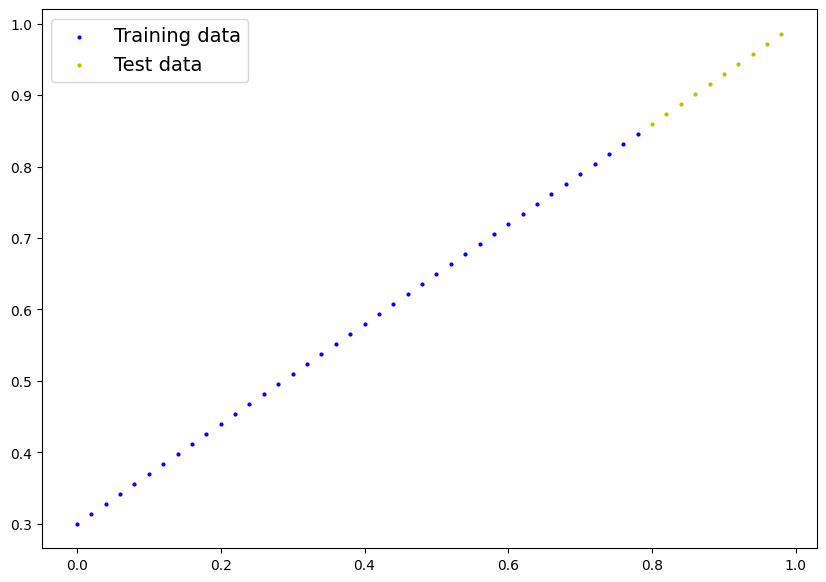

In [30]:
plot_predictions()

## 2. Build model

What our model does:
* Start with random values (weights & bias)
* Look at training data and adjust the random values to better represent the ideal values

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [31]:
from torch import nn
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch model building essential

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graphs)
* torch.nn.Parameter- what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, need to override forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - this method defines what happens in the forward computation

### Checking the contents of our PyTorch models

We can check our model parameters or what's inside our model using .parameters()

In [97]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [61]:
# List named paras
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts y_test based on x_test.

When we pass data through our model, it's going to run it through the `forward()` method.

In [62]:
# Make predictions with model
with torch.inference_mode():  # Turn of gradient tracking -> run faster
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [63]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

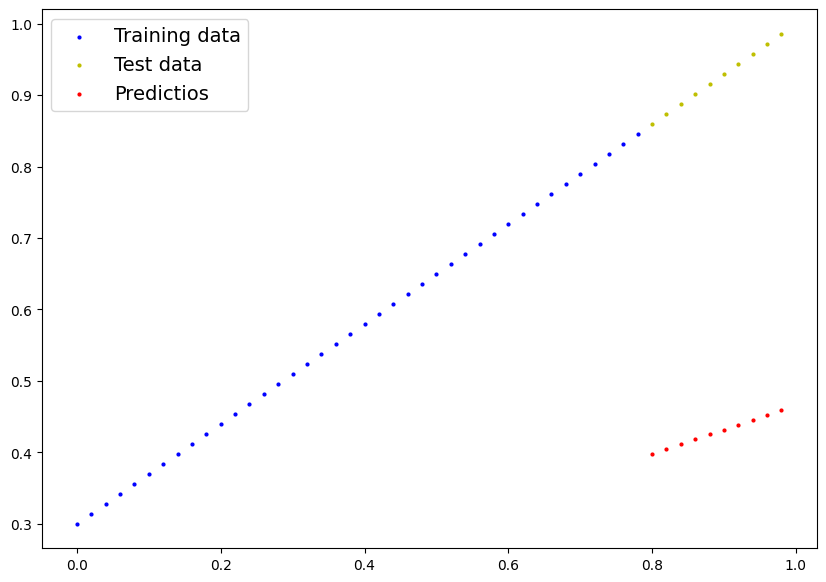

In [64]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some unknown parameters to some known parameters

One way to measure how poor your models are is to use loss function (or cost functions or criteration)

**Loss function** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better

**Optimizer** Takes into account the loss of a model and adjusts the model's parameters to improve the loss function

In PyTorch, we need:
- A training loop
- A testing loop

In [65]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [66]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [98]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)  # lr = learning rate = possibly the most important hyper parameters in ML

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's forward() function) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [99]:
# An epoch is one loop through the data...
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []


### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch set

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop -> we have to zero them above in step 3

  # Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layer)
  with torch.inference_mode():
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happinging
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

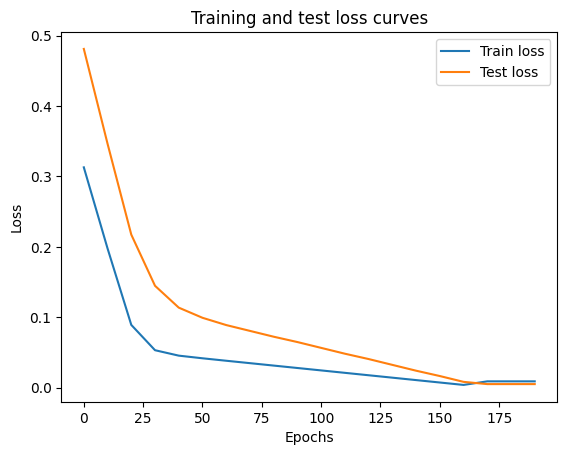

In [102]:
import numpy as np
# Plot the loss curves
plt.plot(epoch_count, torch.Tensor(loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, torch.Tensor(test_loss_values).numpy(), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [77]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [43]:
weight, bias

(0.7, 0.3)

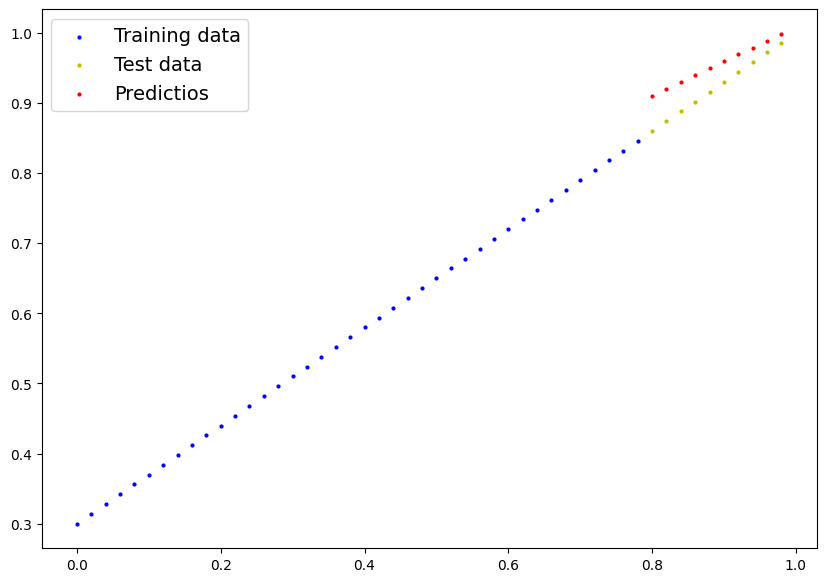

In [100]:
with torch.inference_mode():
  y_preds = model_0(y_test)

plot_predictions(predictions = y_preds)

## Saving a model in PyTorch

There are three main methods for saving and loading models in PyTorch
1. torch.save() - save a PyTorch object in Python's pickle format
2. torch.load() - load a saved PyTorch object
3. torch.nn.Module.load_state_dict() - load a model's saved state dictionary

In [104]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [106]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Mar 23 06:45 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we save `state_dict` rather than entire model, we'll create a new instance of our model class and load the saved state_dict() into that

In [108]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [109]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## 6. Putting it all together
Let's go back through the steps above and see it all in one place

In [110]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

Create device-agnostic code

In [111]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [114]:
# Linear regression V2
class LinearRegressionV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)